In [99]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
from ripser import Rips
import matplotlib.pyplot as plt
from persim import plot_diagrams

def get_molecule(path: str):
    type_map_path = os.path.join(path, 'type_map.raw')
    type_path = os.path.join(path, 'type.raw')
    with open(type_map_path, 'r', encoding = 'utf-8') as map_file:
        file_dat = map_file.read()
        type_maps = dict(enumerate(file_dat.strip('\n').split('\n')))

    with open(type_path, 'r', encoding='utf-8') as type_file:
        lines = list(map(int, type_file.read().strip('\n').split('\n')))
    
    convert = list(map(lambda x: type_maps[x], lines))
    convert_counts = defaultdict(int)
    for con in convert:
        convert_counts[con] += 1
    return convert_counts, convert, type_maps

def get_diagrams(path: str, num_trans:int = 5):
    rips = Rips(maxdim=2, thresh=10, verbose = 0)
    coords_path = os.path.join(path, 'coord.raw')
    total_lines = []
    with open(coords_path, 'r', encoding='utf-8') as coords_file:
        lines = coords_file.readlines()
        len_of_file = len(lines)
        total_lines = [list(map(float, line.split(' '))) for line in lines]
        total_array = np.array(total_lines).reshape((len_of_file, -1, 3))
        subset_array = total_array[:num_trans, ...]

    diagrams = {i: rips.fit_transform(subset_array[i]) for i in range(num_trans)}
    return subset_array, diagrams

def get_atom_color(atom:str):
    jmol = pd.read_csv("./jmol_colors.csv")
    r = jmol[jmol['atom'] == atom]['R'].values[0] / 255.0
    g = jmol[jmol['atom'] == atom]['G'].values[0] / 255.0
    b = jmol[jmol['atom'] == atom]['B'].values[0] / 255.0
    return (r, g, b)

def plot_pers_diagrams(path: str, num_trans: int = 5):
    coords, diagrams = get_diagrams(path=path, num_trans=num_trans)
    fig, axs = plt.subplots(2, num_trans)
    convert_counts, convert, type_map = get_molecule(path)
    type_frame = pd.DataFrame(convert, columns = ['Atom'])
    type_frame['colors'] = type_frame['Atom'].apply(lambda x: get_atom_color(x))
    unq_atoms = type_frame['Atom'].unique()
    for i, (k, v) in enumerate(diagrams.items()):
        axs[1, i].remove()
        axs[1, i] = fig.add_subplot(2, num_trans, num_trans + i + 1, projection='3d')
        coords_frame = pd.DataFrame(coords[i, ...].tolist(), columns = ['x', 'y', 'z'])
        new_frame = pd.concat([type_frame, coords_frame], axis = 1)
        for u in unq_atoms:
            subset = new_frame[new_frame['Atom'] == u]
            axs[1, i].scatter(subset['x'], subset['y'], subset['z'], c = subset['colors'], label = u)
        if i == 0:
            axs[1, i].legend()
        axs[1, i].set_xlabel("x")
        axs[1, i].set_ylabel('y')
        axs[1, i].set_zlabel('z')
        axs[1, i].zaxis._axinfo['juggled'] = (1, 2, 2)

        # Plot pers diag
        plot_diagrams(v, ax=axs[0, i])
    plt.suptitle(f"{path=}")
    plt.tight_layout()
    plt.show()


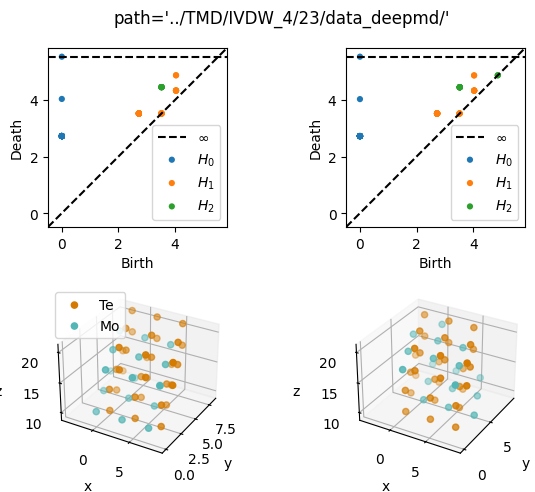

In [100]:
mol_path = "../TMD/IVDW_4/23/data_deepmd/"
plot_pers_diagrams(mol_path, num_trans=2)